# Homework 4

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.constants as C
import astropy.units as u

import chic

from astropy.cosmology import Planck18

$$
\newcommand{\H}{{\rm H}}
\newcommand{\He}{{\rm He}}
$$

# Problem 1: HeRec

Here are my results from part 1.

Saha equation for $\He^0 + \gamma \to \He^+ + e^-$:
$$
\newcommand{\H}{{\rm H}}
\newcommand{\He}{{\rm He}}
\frac{(x_e - 1) \, x_e}{1 + f_\He - x_e}
= \frac{4}{n_\H} \left( \frac{\tilde{m}_e \, T}{2 \pi} \right)^{3/2} e^{-E_1/T},
\quad \tilde{m}_e \equiv \frac{ m_{\He^{+}} }{ m_{\He^{0}} } \, m_e
$$

Saha equation for $\He^+ + \gamma \to \He^{++} + e^-$:
$$
\frac{(x_e - 1 - f_\He) \, x_e}{1 + 2 f_\He - x_e}
= \frac{1}{n_\H} \left( \frac{\tilde{\tilde{m}}_e \, T}{2 \pi} \right)^{3/2} e^{-E_2/T},
\quad \tilde{\tilde{m}}_e \equiv \frac{ m_{\He^{++}} }{ m_{\He^{+}} } \, m_e
$$

where $E_1 = 24.59 \ \text{eV}$, $E_2 = 54.42 \ \text{eV}$.

Let's compute the tilde-$m_e$'s first, using $m_{\He^0} = 4.002602 \ \text{u}$ (from Wolfram Alpha).

In [2]:
E_1 = 24.59 * u.eV
E_2 = 54.42 * u.eV

m_e = (C.m_e * C.c**2).to(u.eV)
m_p = (C.m_p * C.c**2).to(u.eV)
m_He_0 = 4.002602 * (C.u * C.c**2).to(u.eV)
m_He_1 = E_1 + m_He_0 - m_e
m_He_2 = E_2 + m_He_1 - m_e

m_e_tilde1 = m_He_1 / m_He_0 * m_e
m_e_tilde2 = m_He_2 / m_He_1 * m_e

Now let's work out the conversion between $Y_\He$ and $f_\He$.

$$
Y_\He
 \equiv \frac{\rho_\He}{\rho_b}
      = \frac{m_{\He^0} \, n_{\He^0} + m_{\He^+} \, n_{\He^+} + m_{\He^{++}} \, n_{\He^{++}}}{m_p \, n_p + \sum_{k} m_{\He^k} \, n_{\He^k} }
\approx \frac{m_{\He^0} \, n_\He}{m_p \, n_\H + m_{\He^0} \, n_\He}
      = \left( 1 + \frac{m_p}{m_{\He^0}} \frac{1}{f_\He} \right)^{-1}
$$

$$
\implies f_\He = \frac{m_p}{m_{\He^0}} (Y_\He^{-1} - 1)^{-1}
$$

In [3]:
def helium_fraction(Y_He):
    ratio = (m_p / m_He_0).to(u.dimensionless_unscaled).value
    return ratio / (1 / Y_He - 1)

helium_fraction(0.24)

np.float64(0.07947013099192726)

The only other quantity in the equations that is so far unspecified is $n_\H$. We need it in terms of $\omega_b$.

$$
\omega_b
      = \Omega_b \, h^2
      = \frac{h^2}{\rho_{\rm crit}} \, \rho_b
\approx \frac{h^2}{\rho_{\rm crit}} \left( m_p \, n_\H + m_{\He^0} \, n_\He \right)
      = \frac{h^2}{\rho_{\rm crit}} \left( m_p + f_\He \, m_{\He^0} \right) \, n_\H
$$

$$
\implies n_\H = \frac{\omega_b \, h^{-2} \, \rho_{\rm crit}}{m_p + f_\He \, m_{\He^0}}
$$

In [4]:
h_Planck18 = (Planck18.H0 / (100 * u.km/u.s/u.Mpc)).to(u.dimensionless_unscaled).value
rho_c_Planck18 = Planck18.critical_density0
omega_b_Planck18 = Planck18.Ob0 * h_Planck18**2

def n_H(omega_b, Y_He, h=h_Planck18, rho_c=rho_c_Planck18):
    numer = omega_b / h**2 * rho_c
    denom = (m_p + helium_fraction(Y_He) * m_He_0) / C.c**2
    return (numer / denom).to(1 / u.m**3)

n_H(omega_b_Planck18, 0.24)

<Quantity 0.19133062 1 / m3>

Lastly, our equations are in terms of $T$, but we want $x_e$ as a function of $z$.

During Helium recombination, we don't have any major uncouplings or any particles going non-relativistic, so $g_{*}$ and $g_{*s}$ should be constant. This means that $T \propto a^{-1} = 1 + z$. Supposing we have the temperature $T_0$ at a reference redshift $z_0$, we can get the temperature at another redshift by
$$
T(z) = \frac{1 + z}{1 + z_0} T_0.
$$

For the reference, I'll just use today: $z_0 = 0$, $T_0 = 2.73 \ \text{K}$.

In [5]:
def temperature(z):
    T_0 = (Planck18.Tcmb0 * C.k_B).to(u.eV)
    return (1 + z) * T_0

temperature(1100)

<Quantity 0.25858683 eV>

Finally, we can solve for $x_e$.

Eqn 1:
$$
\newcommand{\RHS}{{\rm RHS}}
\frac{(x_e - 1) \, x_e}{1 + f_\He - x_e} = \RHS
\implies
x_e = \frac{1}{2} \left[ 1 - \RHS + \sqrt{(1 + \RHS)^2 + 4 \, f_\He \, \RHS} \right]
$$

Eqn 2:
$$
\frac{(x_e - 1 - f_\He) \, x_e}{1 + 2 f_\He - x_e} = {\rm RHS}
\implies
x_e = \frac{1}{2} \left[ 1 - \RHS + f_\He + \sqrt{(1 + \RHS + f_\He)^2 + 4 \, f_\He \, \RHS} \right]
$$

For stability, let's consider some limits.

Eqn 1:
$$
\begin{gathered}
\RHS \to 0 \implies \text{numerator} \to 0 \implies x_e \to 1, \\
\RHS \to \infty \implies \text{denominator} \to 0 \implies x_e \to 1 + f_\He
\end{gathered}
$$

Eqn 2:
$$
\begin{gathered}
\RHS \to 0 \implies \text{numerator} \to 0 \implies x_e \to 1 + f_\He, \\
\RHS \to \infty \implies \text{denominator} \to 0 \implies x_e \to 1 + 2 \, f_\He
\end{gathered}
$$

Let's implement these limits in our solutions to the equations. We'll do so by setting thresholds on the value of $\RHS$.

In [6]:
threshold = 1e8

def _equation_1(T, f_He, n_H):
    E_over_T = (E_1 / T).to(u.dimensionless_unscaled).value
    n_H_eV = (n_H * (C.c * C.hbar)**3).to(u.eV**3)
    RHS = 4 * (m_e_tilde1 * T / (2 * np.pi))**(3/2) / n_H_eV * np.exp(-E_over_T)
    RHS = RHS.to(u.dimensionless_unscaled).value

    if RHS > threshold:
        return 1 + f_He
    elif RHS < 1 / threshold:
        return 1
    else:
        return 0.5 * (1 - RHS + np.sqrt((1 + RHS)**2 + 4 * f_He * RHS))

def _equation_2(T, f_He, n_H):
    E_over_T = (E_2 / T).to(u.dimensionless_unscaled).value
    n_H_eV = (n_H * (C.c * C.hbar)**3).to(u.eV**3)
    RHS = (m_e_tilde2 * T / (2 * np.pi))**(3/2) / n_H_eV * np.exp(-E_over_T)
    RHS = RHS.to(u.dimensionless_unscaled).value
    if RHS > threshold:
        return 1 + 2 * f_He
    elif RHS < 1 / threshold:
        return 1 + f_He
    else:
        return 0.5 * (1 - RHS + f_He + np.sqrt((1 + RHS + f_He)**2 + 4 * f_He * RHS))

def electron_fraction(z_arr, omega_b=omega_b_Planck18, Y_He=0.24):
    _f_He = helium_fraction(Y_He)
    
    z_arr = np.sort(z_arr)
    T_arr = temperature(z_arr)

    x_e_arr = np.zeros_like(z_arr)
    switch = False
    for i, (_z, _T) in enumerate(zip(z_arr, T_arr)):
        h = (Planck18.H(_z) / (100 * u.km/u.s/u.Mpc)).to(u.dimensionless_unscaled).value
        rho_c = Planck18.critical_density(_z)
        
        _n_H = n_H(omega_b, Y_He, h=h, rho_c=rho_c)
        
        if not switch:
            x_e_arr[i] = _equation_1(_T, _f_He, _n_H)
            if x_e_arr[i] - (1 + _f_He) == 0:
                # normally want to avoid testing for exact equality, but we modified
                # our equations to return _exactly_ this value under certain conditions
                # so testing for exact equality is A-OK
                x_e_arr[i] = _equation_2(_T, _f_He, _n_H)
                switch = True
        else:
            x_e_arr[i] = _equation_2(_T, _f_He, _n_H)
    return z_arr, x_e_arr

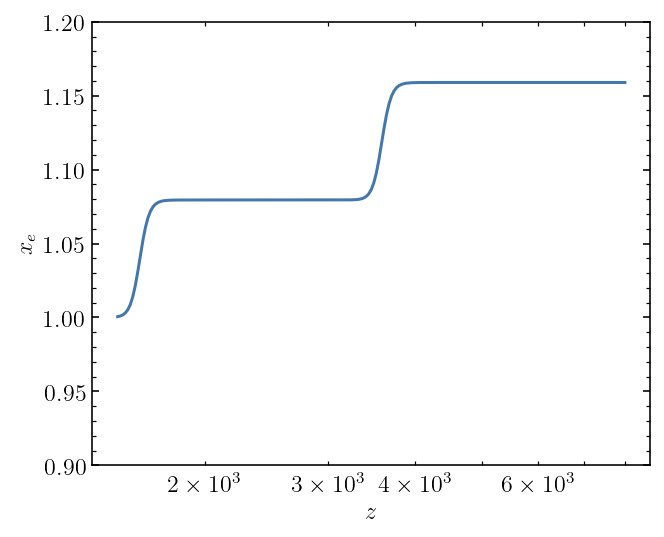

In [7]:
zs = np.geomspace(1500, 8000, 200+1)
zs_He, x_es_He = electron_fraction(zs)
plt.plot(zs_He, x_es_He)
plt.xlabel('$z$')
plt.ylabel('$x_e$')
plt.xscale('log')
plt.ylim(0.9, 1.2)
plt.show()

# Problem 2: Radiative capture

Evaluating the units of my $b_{\rm max}$ quantities:

$$
b_{\rm max, cl} = (4 \pi)^{1/5} \frac{e^2}{m \, v^{7/5}}
$$

In [8]:
(
    (4 * np.pi)**(1/5) * C.e.gauss**2 / (C.m_e * C.c**2)
).decompose()

<Quantity 4.67491549e-15 m>

$$
b_{\rm max} = \left( \frac{4 \pi}{3} \right)^{1/2} \frac{e^3}{m \, v}
$$

In [9]:
(
    (4 * np.pi / 3)**(1/2) * C.e.gauss**3 / (C.m_e * C.c**2) / (C.hbar * C.c)**(1/2)
).decompose()

<Quantity 4.92672999e-16 m>

Fiducial value for $\mathcal{A}_{\rm cl}$

$$
\mathcal{A}_{\rm cl} = \frac{2 \, (2\pi)^{3/2}}{3} \frac{e^6}{m_e^{3/2} \, T^{1/2}}
= \frac{2 \, (2\pi)^{3/2}}{3} \frac{e^6}{(m_e c^2)^{3/2} \, T^{1/2} \hbar}
$$

In [10]:
A_cl = (
    2 * (2 * np.pi)**(3/2) / 3 *
    (C.e.gauss ** 6) / (C.m_e * C.c**2)**(3/2) / (1e4 * u.K * C.k_B)**(1/2) / C.hbar
).to(u.cm**3 * u.s**-1)
A_cl

<Quantity 1.40459694e-13 cm3 / s>

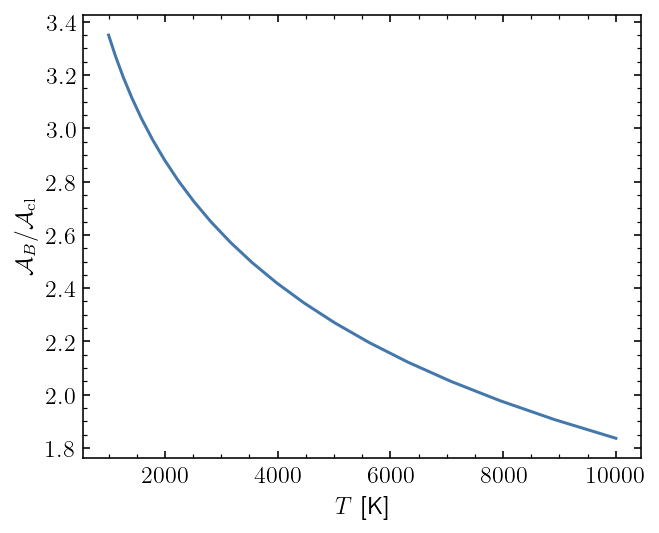

In [11]:
Ts = np.geomspace(1e3, 1e4, 20+1)
T4s = Ts / 1e4

A_cls = A_cl / np.sqrt(T4s)
A_Bs = 4.309 * np.pow(T4s, -0.6166) / (1 + 0.6703 * np.pow(T4s, 0.53)) * (1e-13 * u.cm**3 / u.s)
ratio = A_Bs / A_cls

plt.plot(Ts, ratio)
plt.xlabel('$T$ [K]')
plt.ylabel(r'$\mathcal{A}_{B} / \mathcal{A}_{\rm cl}$')
plt.show()

# Problem 3: HyRec

We want to write a code that takes as inputs

- $T_0$ (CMB temperature today)
- $\omega_b, \omega_m, \omega_\Lambda$
- $N_{\rm eff}$
- $Y_\He$

and outputs $x_e(z)$.

Let's start with the final result. In lecture, we found that the complete ODE for $x_e$ including $2p \to 1s + \gamma$ and $2s \to 1s + \gamma + \gamma$ transitions was given by

$$
\dot{x}_e = -C \left[
    n_\H \, \mathcal{A}_B \, x_e^2
    - 4 \, \mathcal{B}_B \, e^{-E_{21}/T} \, (1 - x_e)
\right]
$$

where

$$
\begin{gathered}
\mathcal{A}_B (T) \approx \frac{4.309 \, (T/10^4 \ \text{K})^{-0.6166}}{1 + 0.6703 \, (T/10^4 \ \text{K})^{0.53}} \times 10^{-13} \ \text{cm}^{3} \, \text{s}^{-1},
\\
4 \, \mathcal{B}_B (T) = 4 \, n_\H \, \mathcal{A}_B (T) \left( \frac{x_e^2}{x_2} \right)_{ {\rm Saha}, \, T }
= n_\H \, \mathcal{A}_B (T) \, e^{+E_{21}/T} \left( \frac{x_e^2}{1 - x_e} \right)_{ {\rm Saha}, \, T },
\\
C(T) = \frac{
    \frac{8\pi H}{\lambda^3 \, n_\H} + \Lambda_{2\gamma}
}{
    \frac{8\pi H}{\lambda^3 \, n_\H} + \Lambda_{2\gamma} + 4 \, \mathcal{B}_B(T)
},
\\
\lambda \equiv h / E_{21} \approx 1216 \ \mathring{A}, \quad
\Lambda_{2\gamma} = 8.22 \ \text{s}^{-1}
\end{gathered}
$$

Plugging $\mathcal{B}_B$ into $\dot{x}_e$, we find

$$
\dot{x}_e = -C(T) \, n_\H \, \mathcal{A}_B (T) \left[
    x_e^2
    -  \left( \frac{x_e^2}{1 - x_e} \right)_{ {\rm Saha}, \, T } \, (1 - x_e)
\right]
$$

In [12]:
def A_B(T: u.Quantity['energy']):
    T4 = T / (1e4 * u.K * C.k_B)
    T4 = T4.to(u.dimensionless_unscaled).value
    return (
        (4.309 * np.pow(T4, -0.6166))
        / (1 + 0.6703 * np.pow(T4, 0.53))
        * (1e-13 * u.cm**3 / u.s)
    )

Now equilibrium is described by the Saha equation:

$$
\left. \frac{x_e^2}{1 - x_e} \right|_{\rm eq} = \frac{1}{n_\H} \left( \frac{\tilde{m}_e \, T}{2 \pi} \right)^{3/2} \, e^{-E_{\rm I}/T},
\quad \tilde{m}_e \equiv \frac{m_p}{m_{\H^0}} \, m_e,
\quad E_{\rm I} = 13.6 \ \text{eV}
$$

We can use this to implement the Peebles' C factor.

In [13]:
m_e = (C.m_e * C.c**2).to(u.eV)
m_p = (C.m_p * C.c**2).to(u.eV)
E_I = 13.6 * u.eV
m_H_0 = (m_p + m_e - E_I)
m_e_tilde = (m_p / m_H_0) * m_e

E_21 = 10.2 * u.eV
lambda_21 = (C.h * C.c / E_21).to(u.Angstrom)
Lambda_2g = 8.22 / u.s

def saha_equilibrium_RHS(T: u.Quantity['energy'], n_H: u.Quantity['number density']):
    E_over_T = (E_I / T).to(u.dimensionless_unscaled).value
    n_H_eV = (n_H * (C.c * C.hbar)**3).to(u.eV**3)
    eV3_ratio = ((m_e_tilde * T) / (2 * np.pi))**(3/2) / n_H_eV
    eV3_ratio = eV3_ratio.to(u.dimensionless_unscaled).value
    RHS = eV3_ratio * np.exp(-E_over_T)
    return RHS

def peebles_C(T: u.Quantity['energy'], n_H: u.Quantity['number density'], H: u.Quantity['frequency'] = 67.6 * u.km/u.s/u.Mpc):
    E21_over_T = (E_21 / T).to(u.dimensionless_unscaled).value
    _A_B = A_B(T)
    x_eq_RHS = saha_equilibrium_RHS(T, n_H)
    numer = (8 * np.pi * H) / (lambda_21**3 * n_H).to(u.dimensionless_unscaled).value + Lambda_2g
    four_B_B = n_H * _A_B * np.exp(E21_over_T) * x_eq_RHS
    return (numer / (numer + four_B_B)).to(u.dimensionless_unscaled).value

print(saha_equilibrium_RHS(1 * u.eV, 1 * u.cm**-3))
print(peebles_C(1 * u.eV, 1 * u.cm**-3))

3741460496403157.0
3.5973473586138553e-07


We also want $n_\H$ in terms of cosmological parameters.

Note that all helium is assumed to be neutral (He recombination is complete!), so charge neutrality means $n_e = n_p$.

We take $n_\H = n_p + n_{\H^0}$ and $\rho_\H = \rho_p + \rho_{\H^0}$. Using that $n_p = x_e \, n_\H$, we can rewrite the energy density as
$$
\rho_\H = (m_p \, x_e + m_{\H^0} \, (1 - x_e)) \, n_\H \equiv \overline m_\H(x_e) \, n_\H
$$
And so
$$
\rho_b = \overline m_\H \, n_H + Y_\He \, \rho_b
\implies
n_\H = \frac{1 - Y_\He}{\overline m_\H} \, \rho_b
$$
In terms of cosmological parameters,
$$
\begin{gathered}
\rho_b(z) = \rho_{b,0} \, (1 + z)^3 
= \omega_b \, h^{-2} \, \rho_{c,0} \, (1 + z)^3
= \frac{3 \, (100 \ \text{km/s/Mpc})^2 \, \omega_b}{8 \pi G} \, (1 + z)^3
\end{gathered}
$$

At this point, we have everything we need to compute $\dot x_e$ at a given $x_e$ and $T$.

In order to integrate this into $x_e(z)$, we need to write the differential equation instead in the form
$$
\frac{d}{dz} x_e = f(z, x_e).
$$

This requires two parts:

1. We need $T(z)$.
2. We need $d x_e/dz$ as a function of $\dot x_e$ and cosmological parameters.

Getting $T(z)$ is easy; in fact we've already done it above.

During hydrogen recombination, there are no species going non-relativistic, so $g_*$ and $g_{*s}$ are constant, meaning that $T \propto a^{-1} = 1 + z$. So, given $T_0 = T(z=0)$, 

$$
T(z) = (1 + z) \, T_0.
$$

In [14]:
T_0_Planck = (2.73 * u.K * C.k_B).to(u.eV)

def temperature(z, T_0: u.Quantity['energy']=T_0_Planck):
    return (1 + z) * T_0

Lastly, we need $dx_e/dz$. By the chain rule,
$$
\frac{d}{dt} = \frac{da}{dt} \frac{dz}{da} \frac{d}{dz} = -\frac{\dot a}{a^2} \frac{d}{dz}
$$
so
$$
\frac{d x_e}{dz} = - \frac{a^2}{\dot{a}} \dot{x}_e = - \frac{\dot{x}_e}{(1+z) \, H}
$$

The Friedmann equation gives
$$
\begin{aligned}
H
&= (100 \ \text{km/s/Mpc}) \left[ \omega_m \, a^{-3} + \omega_r \, a^{-4} + \omega_\Lambda + \omega_k \, a^{-2} \right]^{1/2} \\
&= (100 \ \text{km/s/Mpc}) \left[ \omega_m \, (1+z)^{3} + \omega_r \, (1+z)^{4} + \omega_\Lambda + \omega_k \, (1+z)^{2} \right]^{1/2} \\
\end{aligned}
$$

The last thing we need is to write the $\omega_i$ values in terms of the desired inputs $\omega_m, \omega_\Lambda, N_{\rm eff}, T_0$.

We can compute the radiation density parameter from $T_0$ as follows.
$$
\omega_r
= \Omega_{r,0} \, h^2
= \frac{8 \pi G \, h^2}{3 H^2} \, \rho_{r,0}
= \frac{8 \pi G}{3 (100 \ \text{km/s/Mpc})^2} \, \rho_{r,0}.
$$
Assuming neutrinos are massless, we next have
$$
\rho_{r,0} = \rho_{\gamma,0} + \rho_{\nu,0}
= \frac{\pi^2}{15} \left[ 1 + N_{\rm eff} \, \frac{7}{8} \left(\frac{4}{11}\right)^{4/3} \right] \, T_0^4
$$

Finally, we know
$$
\omega_m \, h^{-2} + \omega_r \, h^{-2} + \omega_\Lambda \, h^{-2} + \omega_k \, h^{-2} = 1.
$$
so we can compute
$$
\omega_k = h^2 - \omega_m + \omega_r + \omega_\Lambda
$$

In [15]:
def omega_r(T_0: u.Quantity['energy'], N_eff):
    prefactor = (8 * np.pi**3 * C.G) / (45 * (100 * u.km/u.s/u.Mpc)**2)
    prefactor = (prefactor / C.c**5 / C.hbar**3).to(u.eV**-4)
    return (prefactor * (1 + N_eff * 7/8 * (4/11)**(4/3)) * T_0**4).to(u.dimensionless_unscaled).value

omega_r(2.73 * u.K * C.k_B, 3.04)

np.float64(4.20800953368113e-05)

In [16]:
def omega_k(omega_m, omega_L, omega_r, h=0.6766):
    return h**2 - omega_m - omega_r - omega_L

In [17]:
from scipy.integrate import solve_ivp

class Solver:
    def __init__(
        self,
        T_0: u.Quantity['energy'],
        omega_b,
        omega_m,
        omega_L,
        N_eff,
        Y_He,
        h=0.6766
    ):
        self.T_0 = T_0
        self.omega_b = omega_b
        self.omega_m = omega_m
        self.omega_L = omega_L
        self.N_eff = N_eff
        self.Y_He = Y_He
        self.h = h
        
        self.omega_r = omega_r(T_0, N_eff)
        self.omega_k = omega_k(self.omega_m, self.omega_L, self.omega_r, h=self.h)

        self.rho_b_0 = self.omega_b * 3 * (100 * u.km/u.s/u.Mpc)**2 / (8 * np.pi * C.G) * C.c**2
        self.rho_b_0 = self.rho_b_0.to(u.eV / u.cm**3)

    def hubble(self, z):
        return (100 * u.km/u.s/u.Mpc) * np.sqrt(
            self.omega_m * (1 + z)**3
            + self.omega_r * (1 + z)**4
            + self.omega_L
            + self.omega_k * (1 + z)**2
        )

    def temperature(self, z):
        return (1 + z) * self.T_0

    def hydrogen_density(self, z, x_e):
        H = self.hubble(z)
        m_H_bar = m_p * x_e + m_H_0 * (1 - x_e)
        rho_b = self.rho_b_0 * (1 + z)**3
        return (1 - self.Y_He) * rho_b / m_H_bar

    def saha(self, z, max_iter=100):
        x_e_0 = 1
        
        for i in range(max_iter):
            eq_RHS = saha_equilibrium_RHS(self.temperature(z), self.hydrogen_density(z, x_e_0))
            new_x_e_0 = 0.5 * (np.sqrt(eq_RHS**2 + 4 * eq_RHS) - eq_RHS)
            if abs(new_x_e_0 - x_e_0) < 1e-4:
                return new_x_e_0
            x_e_0 = new_x_e_0
        else:
            print(f'warning: Saha did not converge in {max_iter} iterations')
            return x_e_0

    def x_e_dot(self, x_e, T, H, n_H):
        _A = A_B(T)
        _C = peebles_C(T, n_H, H)
        saha = saha_equilibrium_RHS(T, n_H)
        return - _C * n_H * _A * (x_e**2 - saha * (1 - x_e))

    def dxe_dz(self, z, x_e):
        _T = self.temperature(z)
        _H = self.hubble(z)
        _n_H = self.hydrogen_density(z, x_e)
        _x_e_dot = self.x_e_dot(x_e, _T, _H, _n_H)
        _output = - (_x_e_dot / ((1 + z) * self.hubble(z)))
        _output = _output.to(u.dimensionless_unscaled).value
        return _output

    def solve(self, z_0=1500, z_1=200, z_eval=None):
        x_e_0 = self.saha(z_0)
        print(f"Initial x_e: {x_e_0:.4f}")

        return solve_ivp(
            self.dxe_dz,
            (z_0, z_1),
            np.array([x_e_0]),
            t_eval=z_eval
        )

h_PL18 = (Planck18.H0 / (100 * u.km/u.s/u.Mpc)).to(u.dimensionless_unscaled).value

solver = Solver(
    C.k_B * Planck18.Tcmb0,
    omega_b=Planck18.Ob0 * h_PL18**2,
    omega_m=Planck18.Om0 * h_PL18**2,
    omega_L=Planck18.Ode0 * h_PL18**2,
    N_eff=Planck18.Neff,
    Y_He=0.24,
    h=h_PL18,
)

In [18]:
z_eval = np.linspace(1500 - 1e-8, 200 + 1e-8, num=200)
result = solver.solve(1500, 200, z_eval)
result

Initial x_e: 0.9477


  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 1.500e+03  1.493e+03 ...  2.065e+02  2.000e+02]
        y: [[ 9.477e-01  9.472e-01 ...  3.878e-04  3.831e-04]]
      sol: None
 t_events: None
 y_events: None
     nfev: 158
     njev: 0
      nlu: 0

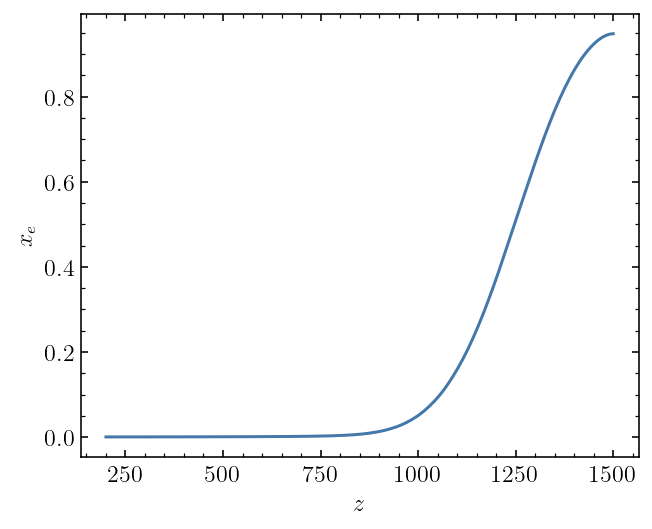

In [19]:
plt.plot(result.t, result.y.squeeze())
plt.xlabel('$z$')
plt.ylabel('$x_e$')
plt.show()

Download and compile HYREC-2.

In [20]:
![ ! -d "HYREC-2" ] && \
git clone https://github.com/nanoomlee/HYREC-2.git

In [21]:
!cd "HYREC-2" && \
gcc -lm -O3 hyrectools.c helium.c hydrogen.c history.c energy_injection.c hyrec.c -o hyrec && \
cd ..

Make a HyRec input file.

In [22]:
lines = [
    # our parameters
    f"{h_PL18:.4f}",
    f"{Planck18.Tcmb0.to(u.K).value}",
    f"{Planck18.Ob0}",
    f"{Planck18.Om0}",
    f"{solver.omega_k / solver.h**2}",
    "-1 0",  # cosmological constant eq of state
    "0.",  # num massive neutrinos
    "0.",  # neutrino mass 1
    "0.",  # neutrino mass 2
    "0.",  # neutrino mass 3
    "0.245",  # Y_He
    f"{Planck18.Neff}",

    # parameters we aren't using; set to defaults
    "1.",
    "1.",
    "0.",
    "0.",
    "0.",
    "0.",
    "0.",
    "0.",
    "0.",
    "0",
    "0.",
    "1.",
    "0.",
]

with open("hyrec_input.dat", "w") as f:
    f.writelines([f"{l}\n" for l in lines])

Run HYREC-2 on our input.

In [23]:
!cd HYREC-2 && ./hyrec < ../hyrec_input.dat && cd ..

Enter Hubble parameter (h) : 
Enter CMB temperature today [Kelvin]: 
Enter baryon density, Omega_b: 
Enter matter (CDM+baryons) density, Omega_cb: 
Enter curvature, Omega_k: 
Enter dark energy equation of state parameters, w wa: Enter number of massive neutrino species, Nmnu: 
Enter mass of neutrino1, mnu: 
Enter mass of neutrino2, mnu: 
Enter mass of neutrino3, mnu: 
Enter primordial helium mass fraction, Y: 
Enter total effective number of neutrino species, N_eff: 
ratio of fine structure constant at recombination to today's value, fsR: 
ratio of electron mass at recombination to today's value, meR: 
dark matter annihilation parameter, in cm^3/s/GeV, pann: 
pann_halo: 
ann_z: 
ann_zmax: 
ann_zmin: 
ann_var: 
ann_z_halo: 
on_the_spot: 
decay: 
Mpbh: 
fpbh: 



Read the data

In [24]:
data = np.loadtxt(
    'HYREC-2/output_xe.dat',
    dtype={
        'names': ('z', 'x_e', 'T_m'),
        'formats': ('<f8', '<f8', '<f8'),
    }
)

z = data['z']
x_e = data['x_e']

mask = (z >= 200) & (z <= 1500)
z_HYREC = z[mask]
x_e_HYREC = x_e[mask]

In [25]:
x_e_saha = [solver.saha(z) for z in result.t]

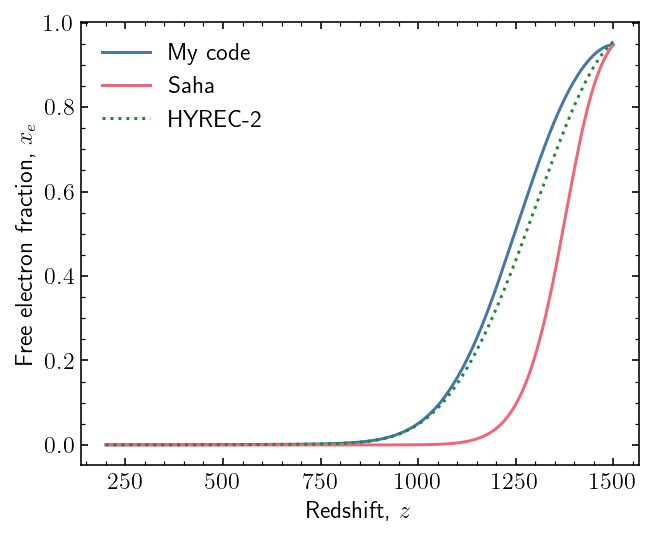

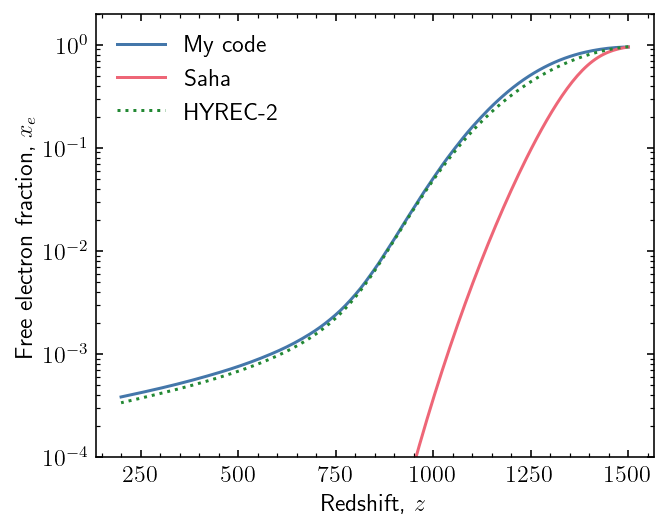

In [26]:
plt.plot(result.t, result.y.squeeze())
plt.plot(result.t, x_e_saha)
plt.plot(z_HYREC, x_e_HYREC, ls=':')

plt.xlabel('Redshift, $z$')
plt.ylabel('Free electron fraction, $x_e$')

plt.legend(['My code', 'Saha', 'HYREC-2'], loc='upper left', frameon=False)
plt.show()


plt.plot(result.t, result.y.squeeze())
plt.plot(result.t, x_e_saha)
plt.plot(z_HYREC, x_e_HYREC, ls=':')

plt.yscale('log')
plt.ylim(1e-4, 2)
plt.xlabel('Redshift, $z$')
plt.ylabel('Free electron fraction, $x_e$')

plt.legend(['My code', 'Saha', 'HYREC-2'], loc='upper left', frameon=False)
plt.show()